In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from datetime import datetime

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from inference.models import RaceEstimatorModel

2024-01-28 20:18:35.519072: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 20:18:35.548138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 20:18:35.548185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 20:18:35.548206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 20:18:35.553566: I tensorflow/core/platform/cpu_feature_g

In [2]:
SIZE=48
BATCH_SIZE=200
NUM_CLASSES=5
EPOCHS=150
LR=0.0005

DATASET_PATH="../data/UTKFace_48"
LOG_PATH="../../logs/race"
MODEL_PATH="../../models/race_model_torch.pth"
WEIGHTS_PATH="../../models/race_model_weights.pth"
TEST_IMAGE_PATH="../data/face_recognition_images/person1.1.jpg"
TIME_FORMAT="%d-%m-%Y; %H:%M:%S"
CLASS_LABELS=["white", "black", "asian", "indian", "others"]

In [3]:
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RaceEstimatorModel(NUM_CLASSES).to(device)

In [5]:
class UTKFaceDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.files = glob.glob(os.path.join(directory, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        image = Image.open(img_name)
        filename = img_name.split('/')[-1]
        race = int(filename.split('_')[2])

        if self.transform:
            image = self.transform(image)

        return image, race

In [6]:
dataset = UTKFaceDataset(directory=DATASET_PATH, transform=transform)
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class_counts = torch.zeros(5)

for _, labels in train_loader:
    class_counts += torch.bincount(labels, minlength=5)

print("Количество экземпляров каждого класса:")
for i, count in enumerate(class_counts):
    print(f"Класс {i}: {int(count)} экземпляров")

Количество экземпляров каждого класса:
Класс 0: 8229 экземпляров
Класс 1: 3834 экземпляров
Класс 2: 2507 экземпляров
Класс 3: 3161 экземпляров
Класс 4: 1320 экземпляров


In [8]:
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [9]:
writer = SummaryWriter(log_dir=LOG_PATH + "/" + datetime.now().strftime(TIME_FORMAT))

for epoch in tqdm(range(EPOCHS)):  # проход по датасету несколько раз
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        writer.add_scalar('Metrics/epoch_loss', running_loss  / len(train_loader), epoch)
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    writer.add_scalar('Metrics/precision', precision, epoch)
    writer.add_scalar('Metrics/recall', recall, epoch)
    writer.add_scalar('Metrics/f1', f1, epoch)
print('Finished Training')

100%|██████████| 150/150 [48:39<00:00, 19.46s/it]

Finished Training


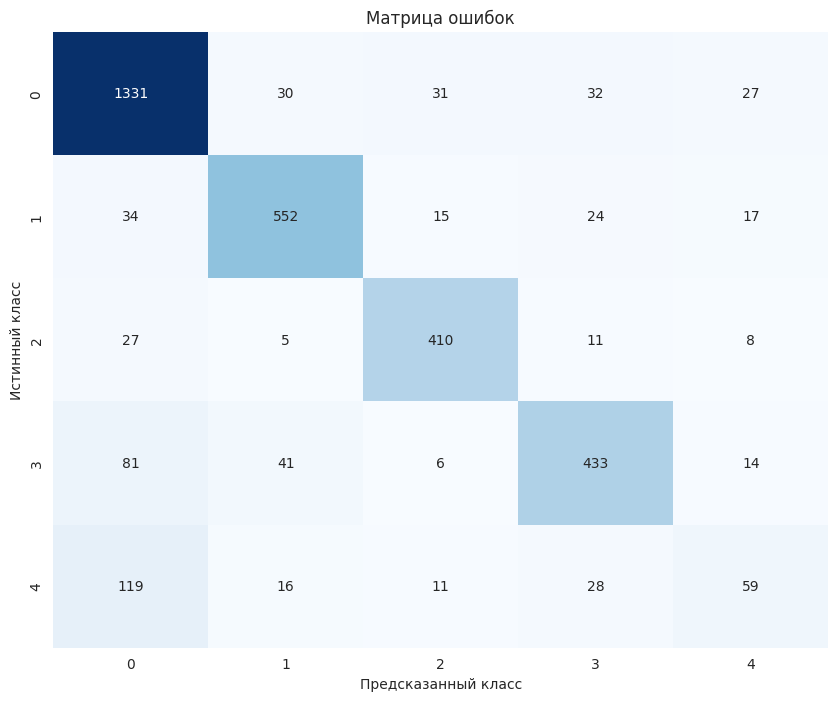

In [10]:
# Функция для вычисления предсказаний
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    return all_labels, all_preds

# Получение предсказаний на валидационном наборе
all_labels, all_preds = get_predictions(model, test_loader)

conf_matrix = confusion_matrix(all_labels, all_preds)

# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

In [11]:
torch.save(model, MODEL_PATH)
torch.save(model.state_dict(), WEIGHTS_PATH)

In [12]:
# model = torch.load(MODEL_PATH)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

image = Image.open(TEST_IMAGE_PATH)
image = transform(image)
image = image.to(device)
image = image.unsqueeze(0)

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_race = predicted.item()

print(f'Predicted Race: {CLASS_LABELS[predicted_race]}')

Predicted Race: white
